# Introducing promptfoo

**Note: This lesson lives in a folder that contains relevant code files. Download the entire folder if you want to follow along and run the evaluation yourself**

We've seen how to write our own evaluations from scratch, which can be effective, if not a little bit cumbersome. It's often more practical to leverage specialized tools designed for this purpose.  There are many evaluation tools and libraries available today (and more being released all the time!) including: 
- [promptfoo](https://github.com/promptfoo/promptfoo)
- [Vellum](https://www.vellum.ai/#playground)
- [Scale Evaluation](https://scale.com/evaluation/model-developers)
- [Prompt Layer](https://promptlayer.com/)
- [Chain Forge](https://github.com/ianarawjo/ChainForge)
- Many others!

Internally, we recommend using promptfoo.  It's open source, fully-featured, and easy to use. It's the tool our own Solutions Architect team prefers to use for their evaluations.  Promptfoo offers a streamlined, out-of-the-box solution that can significantly reduce the time and effort required for comprehensive prompt testing. It provides a simple, ready-made infrastructure for batch testing, version control, and performance analytics, allowing developers to focus more on refining their prompts rather than building and maintaining testing frameworks. It makes it easy to run evaluations across multiple prompts, models, and providers, and it also provides tools to easily visualize and compare evaluation results. It's a huge improvement over trying to write your own evaluation logic from scratch!

After we run our evaluations, promptfoo will generate a dashboard like the one pictured in this image: 

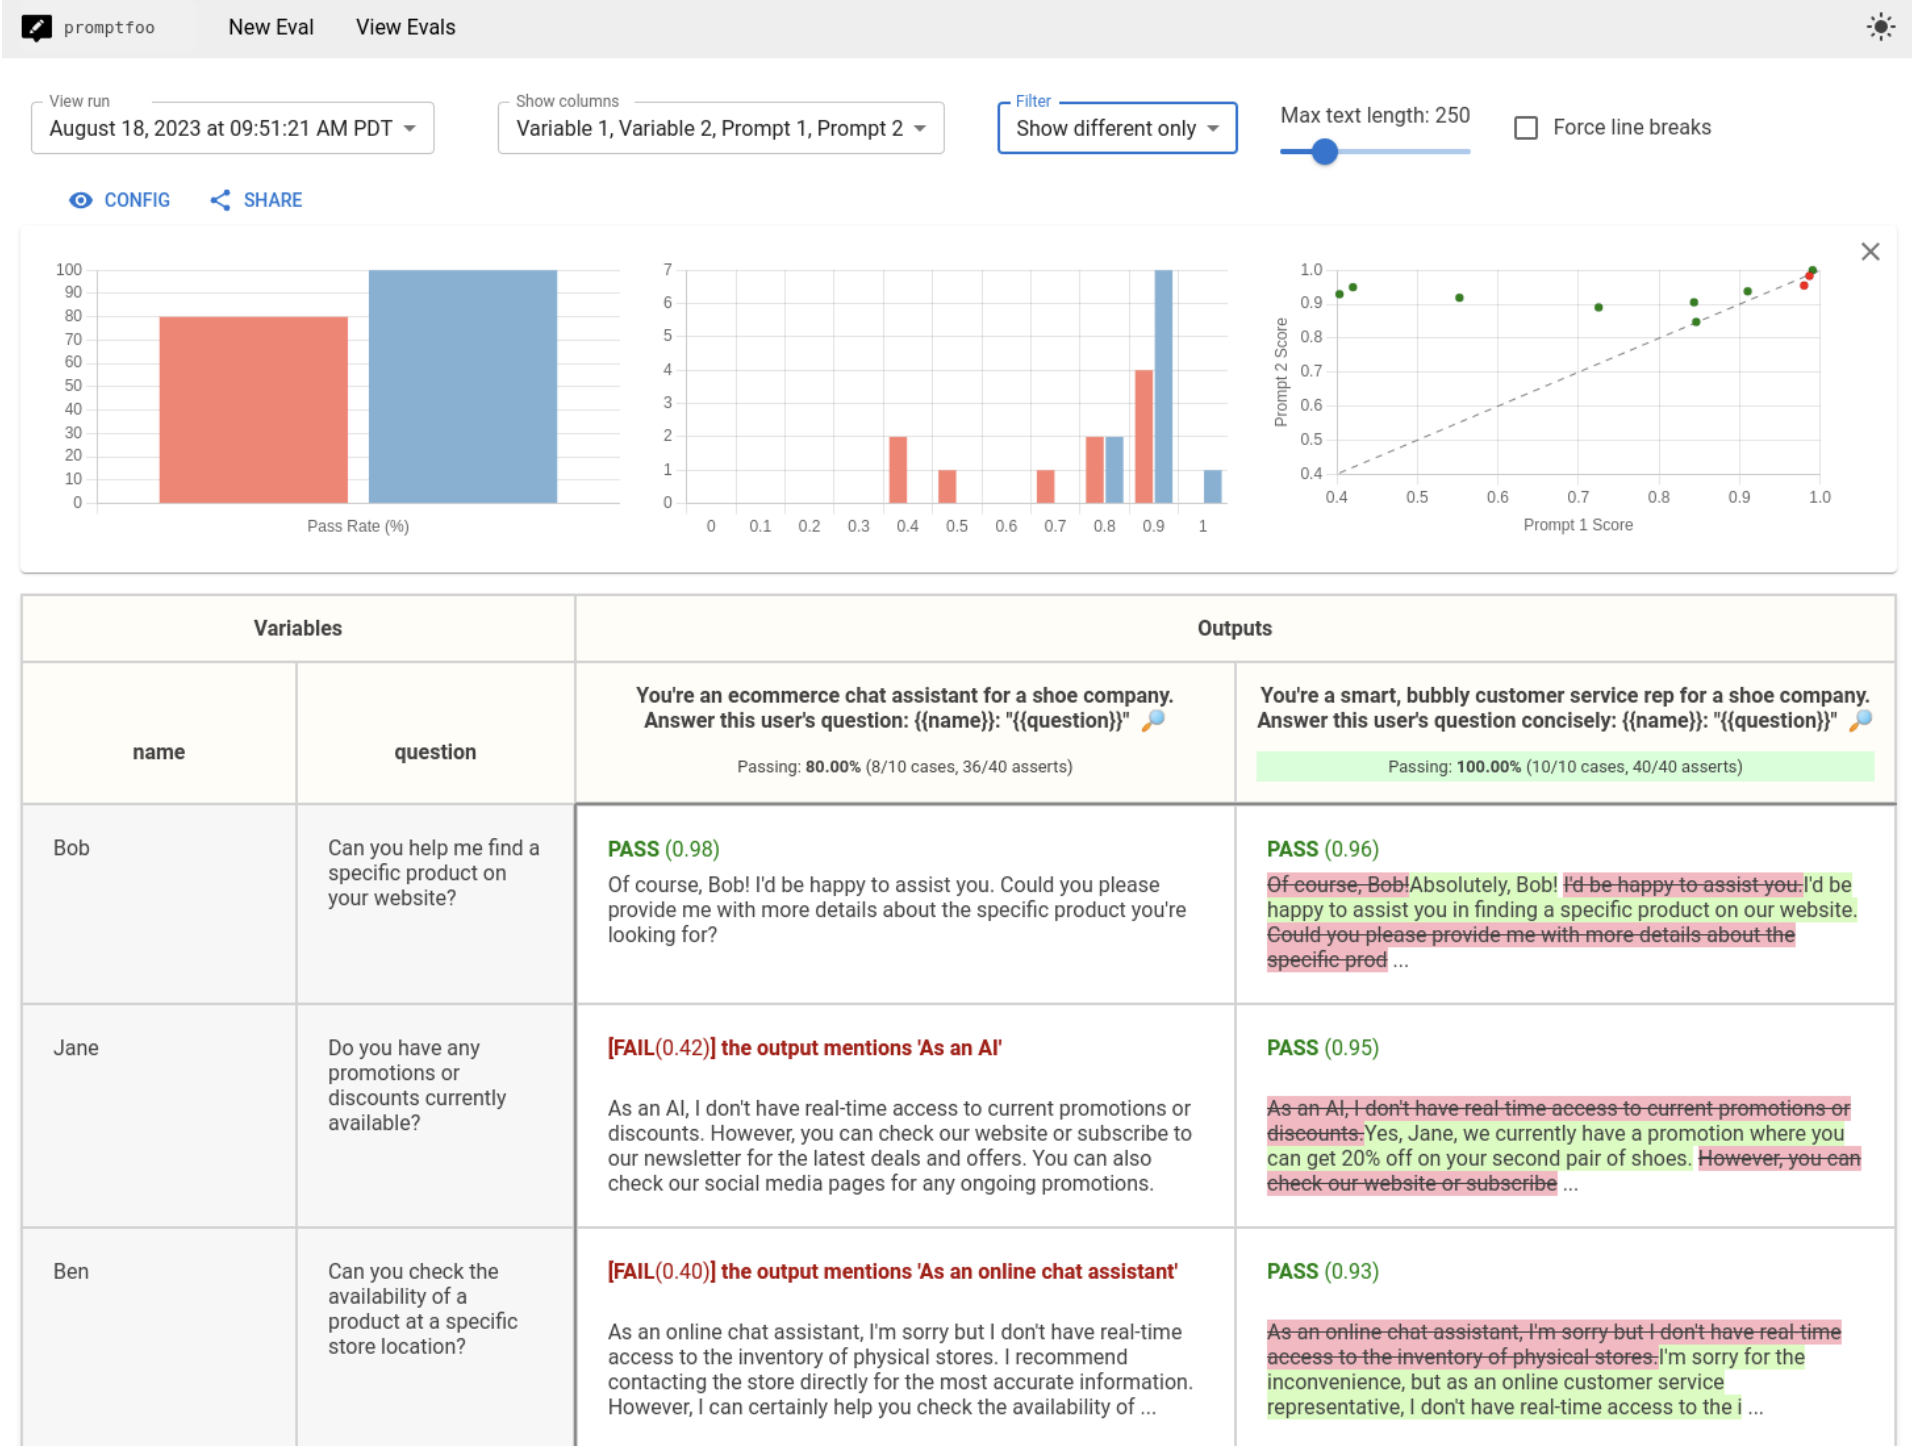

Let's get started!

---

## Our first promptfoo eval

The next few lessons in this course will focus on using promptfoo to write evaluations.  In this first lesson, we'll learn one simple approach to using promptfoo to evaluate our "how many legs does this animal have?" prompt from a few lessons ago.  This is a very simple prompt and evaluation.  Our focus here is on the actual tooling and process of using promptfoo to run evaluations.

As a reminder, in that lesson we used this small evaluation data set: 

```py
eval_data = [
    {"animal_statement": "The animal is a human.", "golden_answer": "2"},
    {"animal_statement": "The animal is a snake.", "golden_answer": "0"},
    {"animal_statement": "The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.", "golden_answer": "5"},
    {"animal_statement": "The animal is a dog.", "golden_answer": "4"},
    {"animal_statement": "The animal is a cat with two extra legs.", "golden_answer": "6"},
    {"animal_statement": "The animal is an elephant.", "golden_answer": "4"},
    {"animal_statement": "The animal is a bird.", "golden_answer": "2"},
    {"animal_statement": "The animal is a fish.", "golden_answer": "0"},
    {"animal_statement": "The animal is a spider with two extra legs", "golden_answer": "10"},
    {"animal_statement": "The animal is an octopus.", "golden_answer": "8"},
    {"animal_statement": "The animal is an octopus that lost two legs and then regrew three legs.", "golden_answer": "9"},
    {"animal_statement": "The animal is a two-headed, eight-legged mythical creature.", "golden_answer": "8"},
]
```

In that lesson, we wrote three different prompts that got progressively better accuracy scores from our rudimentary evaluation functions.  In this lesson we'll port over the evaluation data set and prompts into promptfoo and see how easy it is to run and compare their outputs.

---

## Installing promptfoo

The first step to using promptfoo is to install it via the command line.  Navigate to a folder where you will write your evaluation code and run the following command:

```bash
npx promptfoo@latest init
```

This will create a `promptfooconfig.yaml` file in your current directory.  This file is where all the magic happens.  Inside of it, we configure the following:
- The providers (which Anthropic API models) we want to use in our evaluations
- The prompts we want to evaluate
- The tests we want to run

---



## Configuring the provider(s)
Next, we can configure promptfoo to use the particular Anthropic API models we'd like to run our evaluations with.  To do this, we specify a `providers` field in the `promptfooconfig.yaml` file and set it equal to one or more Anthropic models. Promptfoo uses a specific pattern to specify model names.  The current supported Anthropic model strings are: 

- `anthropic:messages:claude-3-5-sonnet-20240620`
- `anthropic:messages:claude-3-haiku-20240307`
- `anthropic:messages:claude-3-sonnet-20240229`
- `anthropic:messages:claude-3-opus-20240229`
- `anthropic:messages:claude-2.0`
- `anthropic:messages:claude-2.1`
- `anthropic:messages:claude-instant-1.2`

We'll use Haiku for this first evaluation.  Delete the existing contents of the `promptfooconfig.yaml` file and replace it with this:

```yaml
description: "Animal Legs Eval"
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"
```

Here's a breakdown of what each piece does:

- `description` is an optional label describing the task we are evaluating.
- `providers` tells promptfoo we want to use Haiku for this evaluation.  We can specify multiple models, as we'll see in a future lesson.



Promptfoo will look for an `ANTHROPIC_API_KEY` environment variable when running an evaluation.  You can set an environment variable by running this command in your command line: 

```bash
export ANTHROPIC_API_KEY=your_api_key_here
```

---

## Specifying our prompts
The next step is to tell promptfoo about the prompts we want to evaluate.  There are many ways of doing this, including: 
- Putting the prompts directly in the YAML file as text
- Loading prompts from a JSON file
- Loading prompts from a text file
- Loading prompts from another YAML file
- Loading prompts from a Python file

We prefer to put all relevant prompts in a single Python file as individual functions that return prompt strings. In later lessons we'll see alternative approaches.  Promptfoo is quite flexible, as you'll see throughout this course! 

Create a Python file called `prompts.py` and put the following prompt functions inside of it:

```py
def simple_prompt(animal_statement):
    return f"""You will be provided a statement about an animal and your job is to determine how many legs that animal has.
    
    Here is the animal statement.
    <animal_statement>{animal_statement}</animal_statement>
    
    How many legs does the animal have? Please respond with a number"""

def better_prompt(animal_statement):
    return f"""You will be provided a statement about an animal and your job is to determine how many legs that animal has.
    
    Here is the animal statement.
    <animal_statement>{animal_statement}</animal_statement>
    
    How many legs does the animal have? Please only respond with a single digit like 2 or 9"""
```

Notice that each of these functions accepts an `animal_statement` parameter, inserts it into the prompt, and then returns a final prompt string

The next step is to tell the promptfoo configuration file that we want to load our prompts from the `prompts.py` file we just created.  To do this, update the `promptfooconfig.yaml` file to include this code:

```yaml
description: "Animal Legs Eval"

prompts:
  - prompts.py:simple_prompt
  - prompts.py:better_prompt
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"
```

Notice that we add a separate line for each prompt function we added to the `prompts.py` file.  We've told promptfoo that we wish to evaluate both of our prompts: `simple_prompt` and `better_prompt`, both of which "live" in the `prompts.py` file.

---

## Configuring our tests

The next step is telling promptfoo about the particular tests we'd like to run with our specific prompts and providers.  Promptfoo gives us many options for how we define our tests, but we'll start with one of the most common approaches: specifying our tests inside a CSV file.

We'll make a new CSV file called `dataset.csv` and write our test inputs inside of it.  

Promptfoo allows us to define evaluation logic directly inside the CSV file. In upcoming lessons we'll see some of the built-in test assertions that come with promptfoo, but for this particular evaluation all we need to do is look for an exact string match between the model's output and the expected output number of legs.

To do this, we'll write our CSV with two column headers:
- `animal_statement` - contains the input animal statement like "The animal is an elephant" 
- `__expected` - contains the expected correct output (notice the double underscores in __expected).  This is syntax specific to promptfoo.


Create a `dataset.csv` file and add the following to it: 

```csv
animal_statement,__expected
"The animal is a human.","2"
"The animal is a snake.","0"
"The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.","5"
"The animal is a dog.","4"
"The animal is a cat with two extra legs.","6"
"The animal is an elephant.","4"
"The animal is a bird.","2"
"The animal is a fish.","0"
"The animal is a spider with two extra legs","10"
"The animal is an octopus.","8"
"The animal is an octopus that lost two legs and then regrew three legs.","9"
"The animal is a two-headed, eight-legged mythical creature.","8"
```

Finally, we'll tell promptfoo that it should use our `dataset.csv` file to load tests from.  To do this, update the `promptfooconfig.yaml` file to include this code: 

```yaml
description: "Animal Legs Eval"

prompts:
  - prompts.py:simple_prompt
  - prompts.py:better_prompt
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"

tests: animal_legs_tests.csv
```

---


## Running our evaluation

Now that we've specified our provider, prompts, and tests, it's time to run the evaluation! 

In your terminal run the following command:

```bash
npx promptfoo@latest eval
```
This will start the evaluation process.  For each of our prompts, promptfoo will:
- Take each `animal_statement` from the CSV file
- Build the complete prompt that includes the `animal_statement`
- Send a request off to the Anthropic API with the individual prompt
- Check if the output matches the expected output from our CSV file

Once the evaluation is complete, promptfoo will display the results in the terminal.


This is an example promptfoo output from running the two above code: 

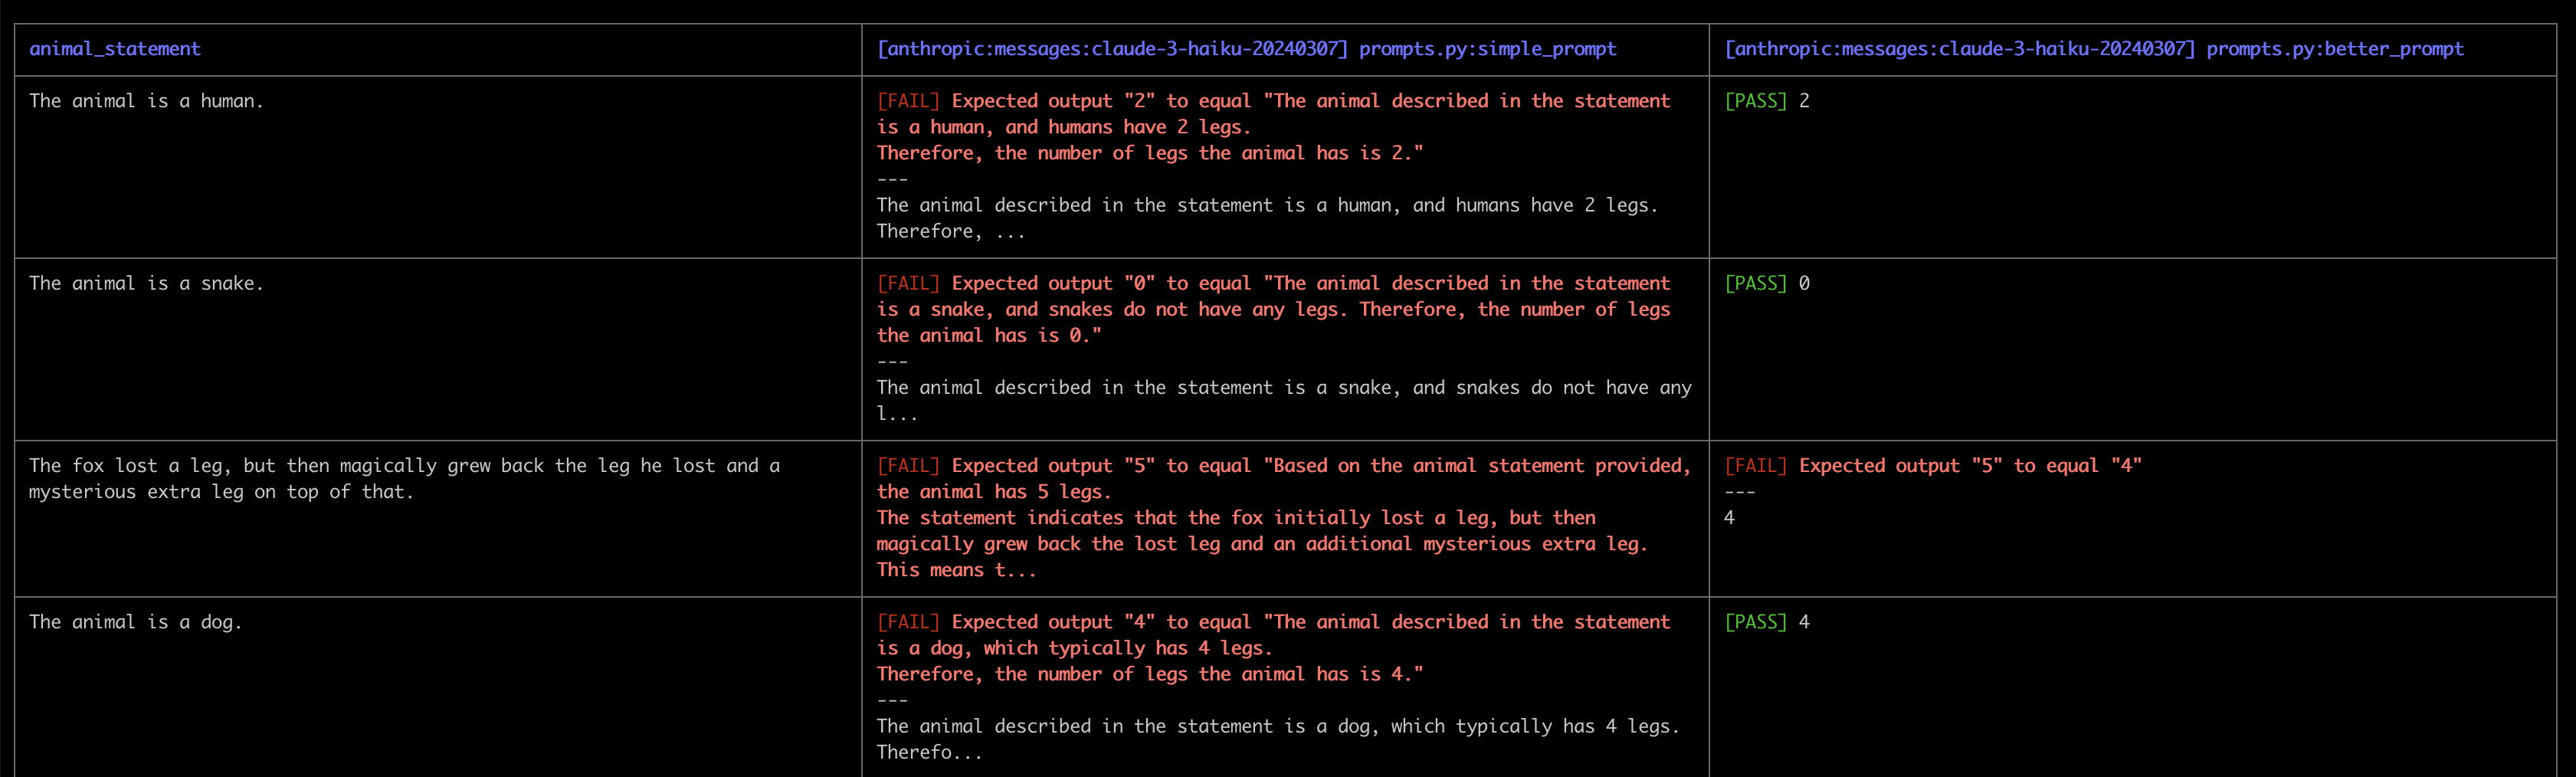

The above screenshot only includes the first four rows, but the evaluation did run on all twelve inputs. 
- The left column shows the specific `animal_statement`
- The middle column shows the output and score for `simple_prompt`, which seems to fail every single test case!
- The right column shows the output and score for `better_prompt`, which succeeds on most test cases except for the logically complicated ones.

---

## Viewing the evaluation

Promptfoo makes it very easy to launch a dashboard to visualize and inspect evaluation results in your browser.  After running the above eval, try running this command in your terminal: 

```bash
npx promptfoo@latest view
```

This will ask you if you want to start a server (type 'y') and then open up a dashboard in your browser.

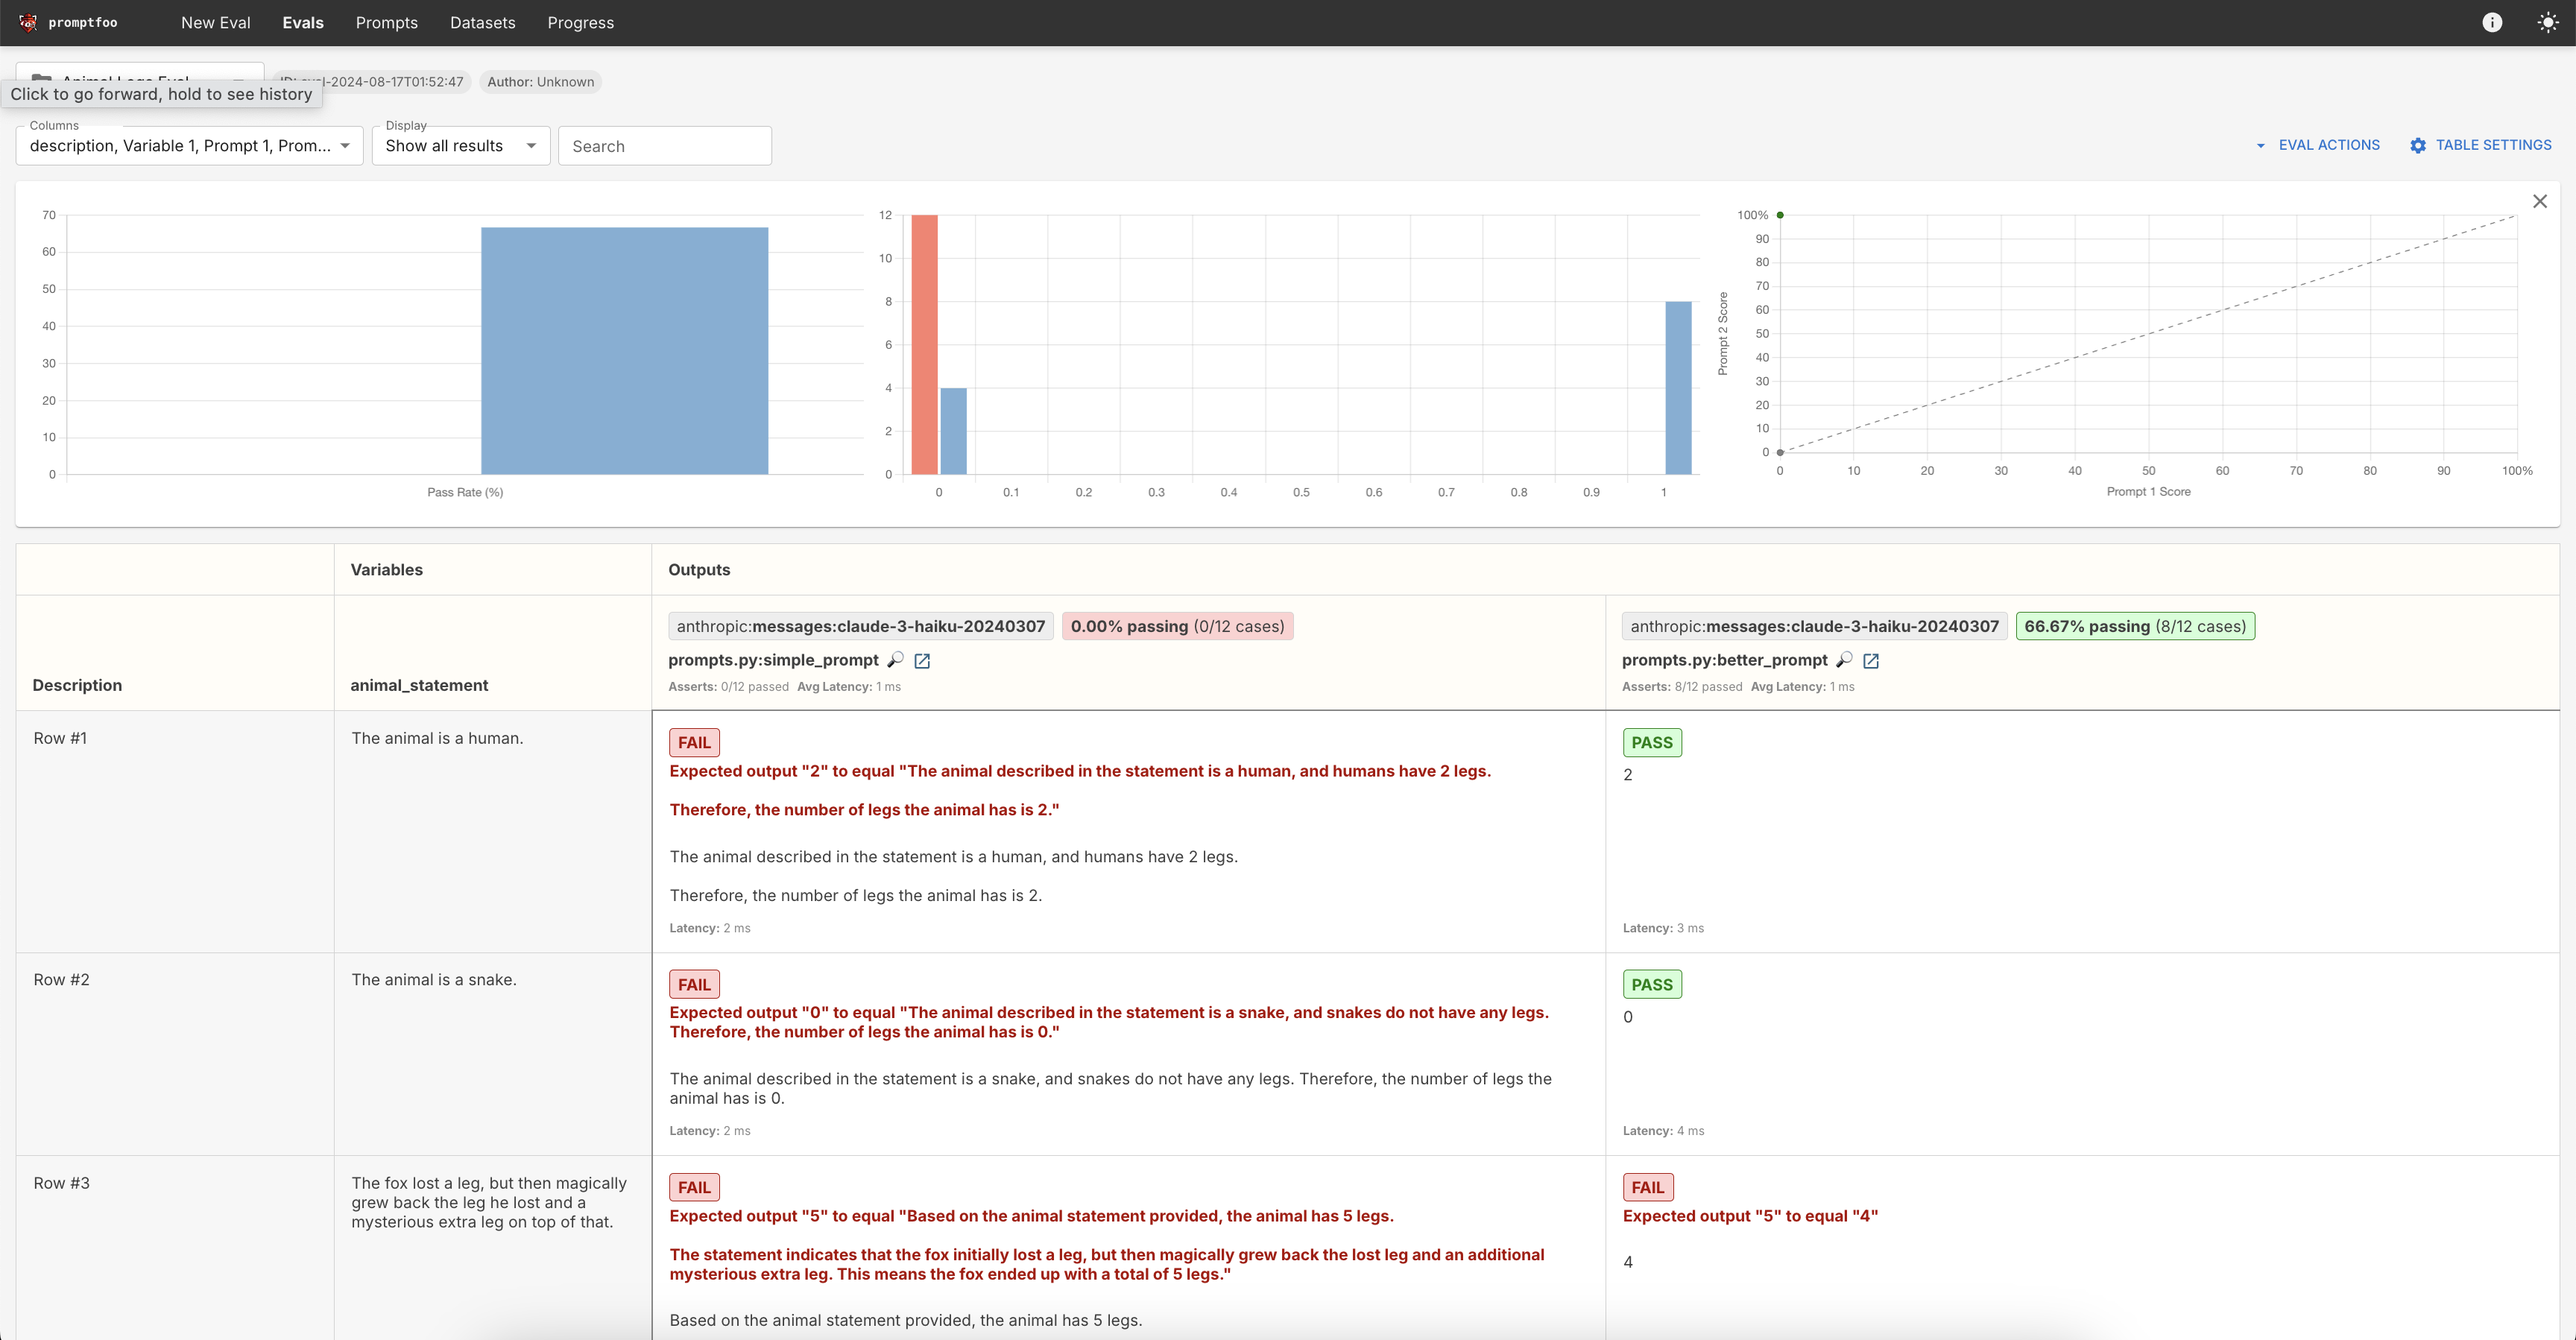

The most relevant summary information is up at the top: 

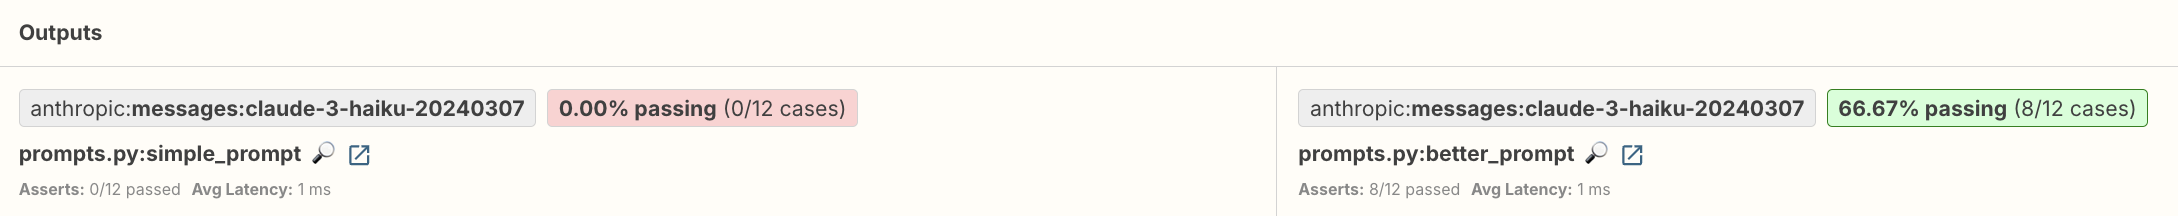

We can also hone in on specific results to understand why they failed.  Let's take a look at one of the `simple_prompt` results (the middle column).  Every single one of the rows are marked as a failure for this prompt.  What's going on? 

Click on the magnifying glass button in a cell to learn more:

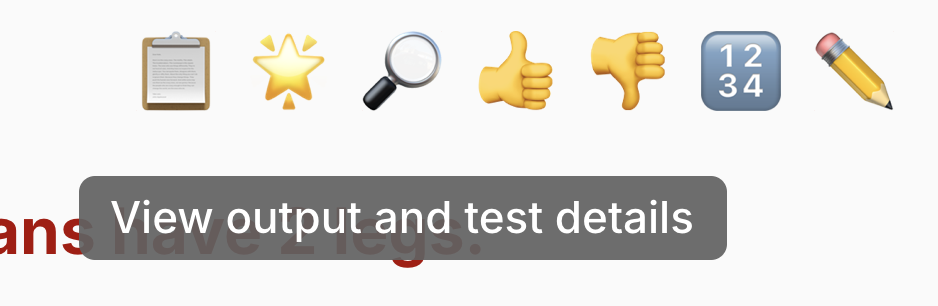

This opens up a modal containing specific details on the output and scoring:

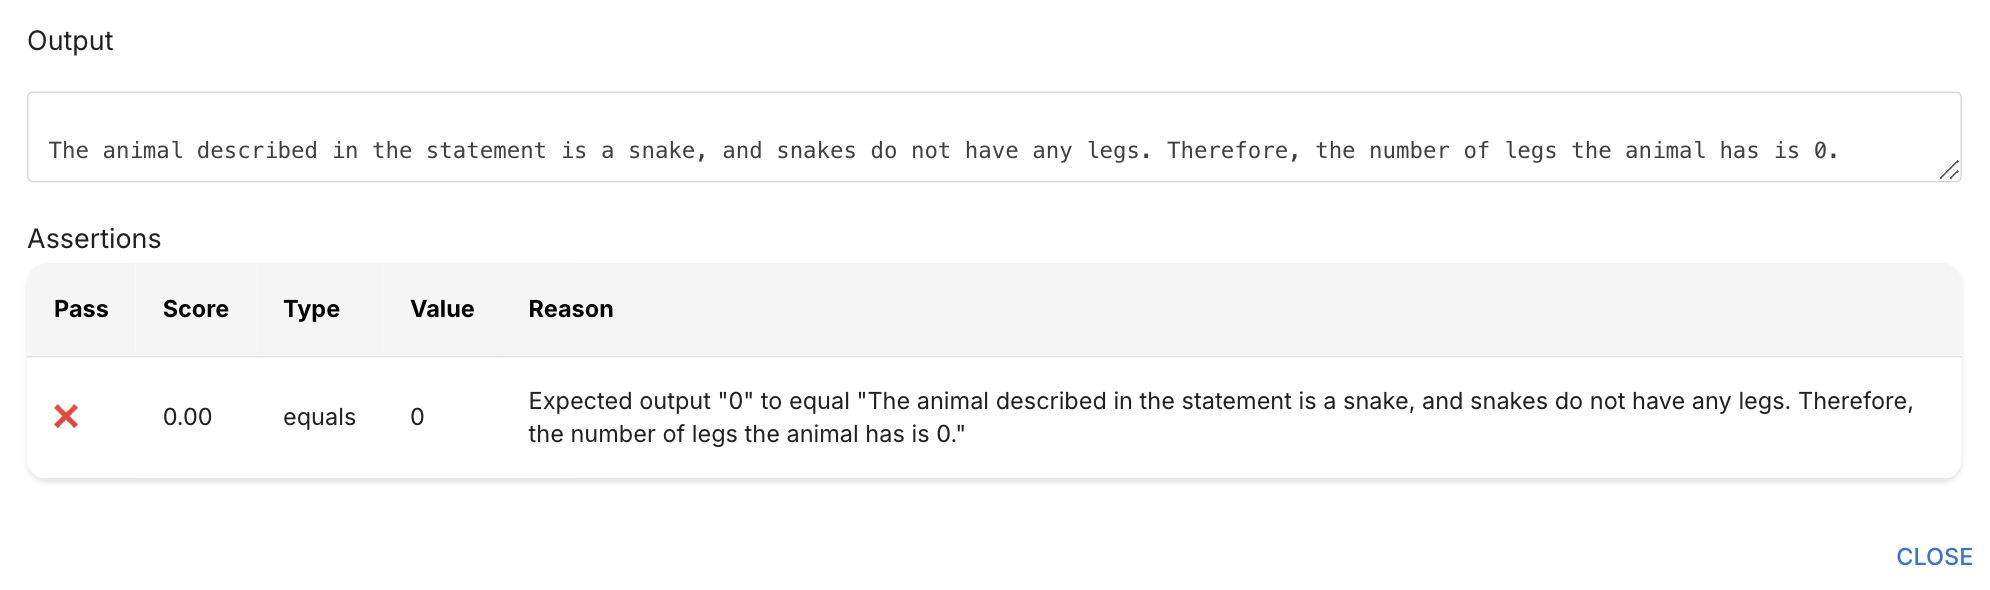

We can clearly see that this `simple_prompt` go the correct answer of 0, but the output includes a bunch of additional unwanted explanatory text that is causing it to fail the evaluation.

If we look closer at the far right column, which contains the results of our `better_prompt` prompt, we're getting much better responses that are all single digits like `5` or `0`.  It seems to be failing on the more complicated `animal_statements` that require more reasoning to answer like: 

> The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.

---


## Adding in a third prompt
Recall from the earlier lesson on code-graded evaluations that we eventually got the best results by adding some Chain of Thought reasoning to our prompt.  Let's add an improved third prompt that includes Chain of Thought and see how it performs on the "trickier" questions!

Add the following prompt function to `prompts.py`:

```py
def chain_of_thought_prompt(animal_statement):
    return f"""You will be provided a statement about an animal and your job is to determine how many legs that animal has.
    
    Here is the animal statement.
    <animal_statement>{animal_statement}</animal_statement>
    
    How many legs does the animal have? 
    Start by reasoning about the numbers of legs the animal has, thinking step by step inside of <thinking> tags.  
    Then, output your final answer inside of <answer> tags. 
    Inside the <answer> tags return just the number of legs as an integer and nothing else."""
```

Next, update the `promptfooconfig.yaml` file to include our new prompt:


```yaml
description: "Animal Legs Eval"

prompts:
  - prompts.py:simple_prompt
  - prompts.py:better_prompt
  - prompts.py:chain_of_thought_prompt
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"

tests: animal_legs_tests.csv
```


Before we can run this evaluation, we have to remedy one issue: our new `chain_of_thought_prompt` responds with `<thinking>` and `<answer>` tags in its output.  To really evaluate how well the model is performing with this prompt, we need to extract the numeric answer the model puts inside of `<answer>` tags and compare that to the expected value.

Promptfoo allows us to define custom `transforms` that we can use to manipulate a model's outputs before doing the actual comparison logic. To this, we'll write a simple Python function that extracts the answer from between the `<answer>` tags.

Make a new file called `transform.py` and add the following code to it:


```py
def get_transform(output, context):
    if "<thinking>" in output:
        try:
            return output.split("<answer>")[1].split("</answer>")[0].strip()
        except Exception as e:
            print(f"Error in get_transform: {e}")
            return output
    return output
```


This function, called `get_transform`, expects to be passed a model's output (we'll cover the `context` parameter in a future lesson).  We can then transform the model's output into any shape we want before returning it.  In this particular case, we do one of two things:

- If the output contains `<thinking>` tags, we know it's an output from our Chain of Thought prompt.  We extract the number from between the `<answer>` tags and return it as the new output.
- Otherwise just return the original output (for the other prompts that don't use Chain of Thought)

The final step is to tell promptfoo that we want to use this transformation function. Update the `promptfooconfig.yaml` file to look like this: 

```yaml
description: "Animal Legs Eval"

prompts:
  - prompts.py:simple_prompt
  - prompts.py:better_prompt
  - prompts.py:chain_of_thought_prompt
  
providers:
  - "anthropic:messages:claude-3-haiku-20240307"

tests: animal_legs_tests.csv

defaultTest:
  options:
    transform: file://transform.py
```

The bit at the end tells promptfoo to always apply the transformation function from our `transform.py` on all tests.  By default, promptfoo will look for a function called `get_transform` inside the `transform.py` file.

Now we can run our evaluation again using:

```bash
npx promptfoo@latest eval
```

We'll see something like this output, which now includes 4 columns: 

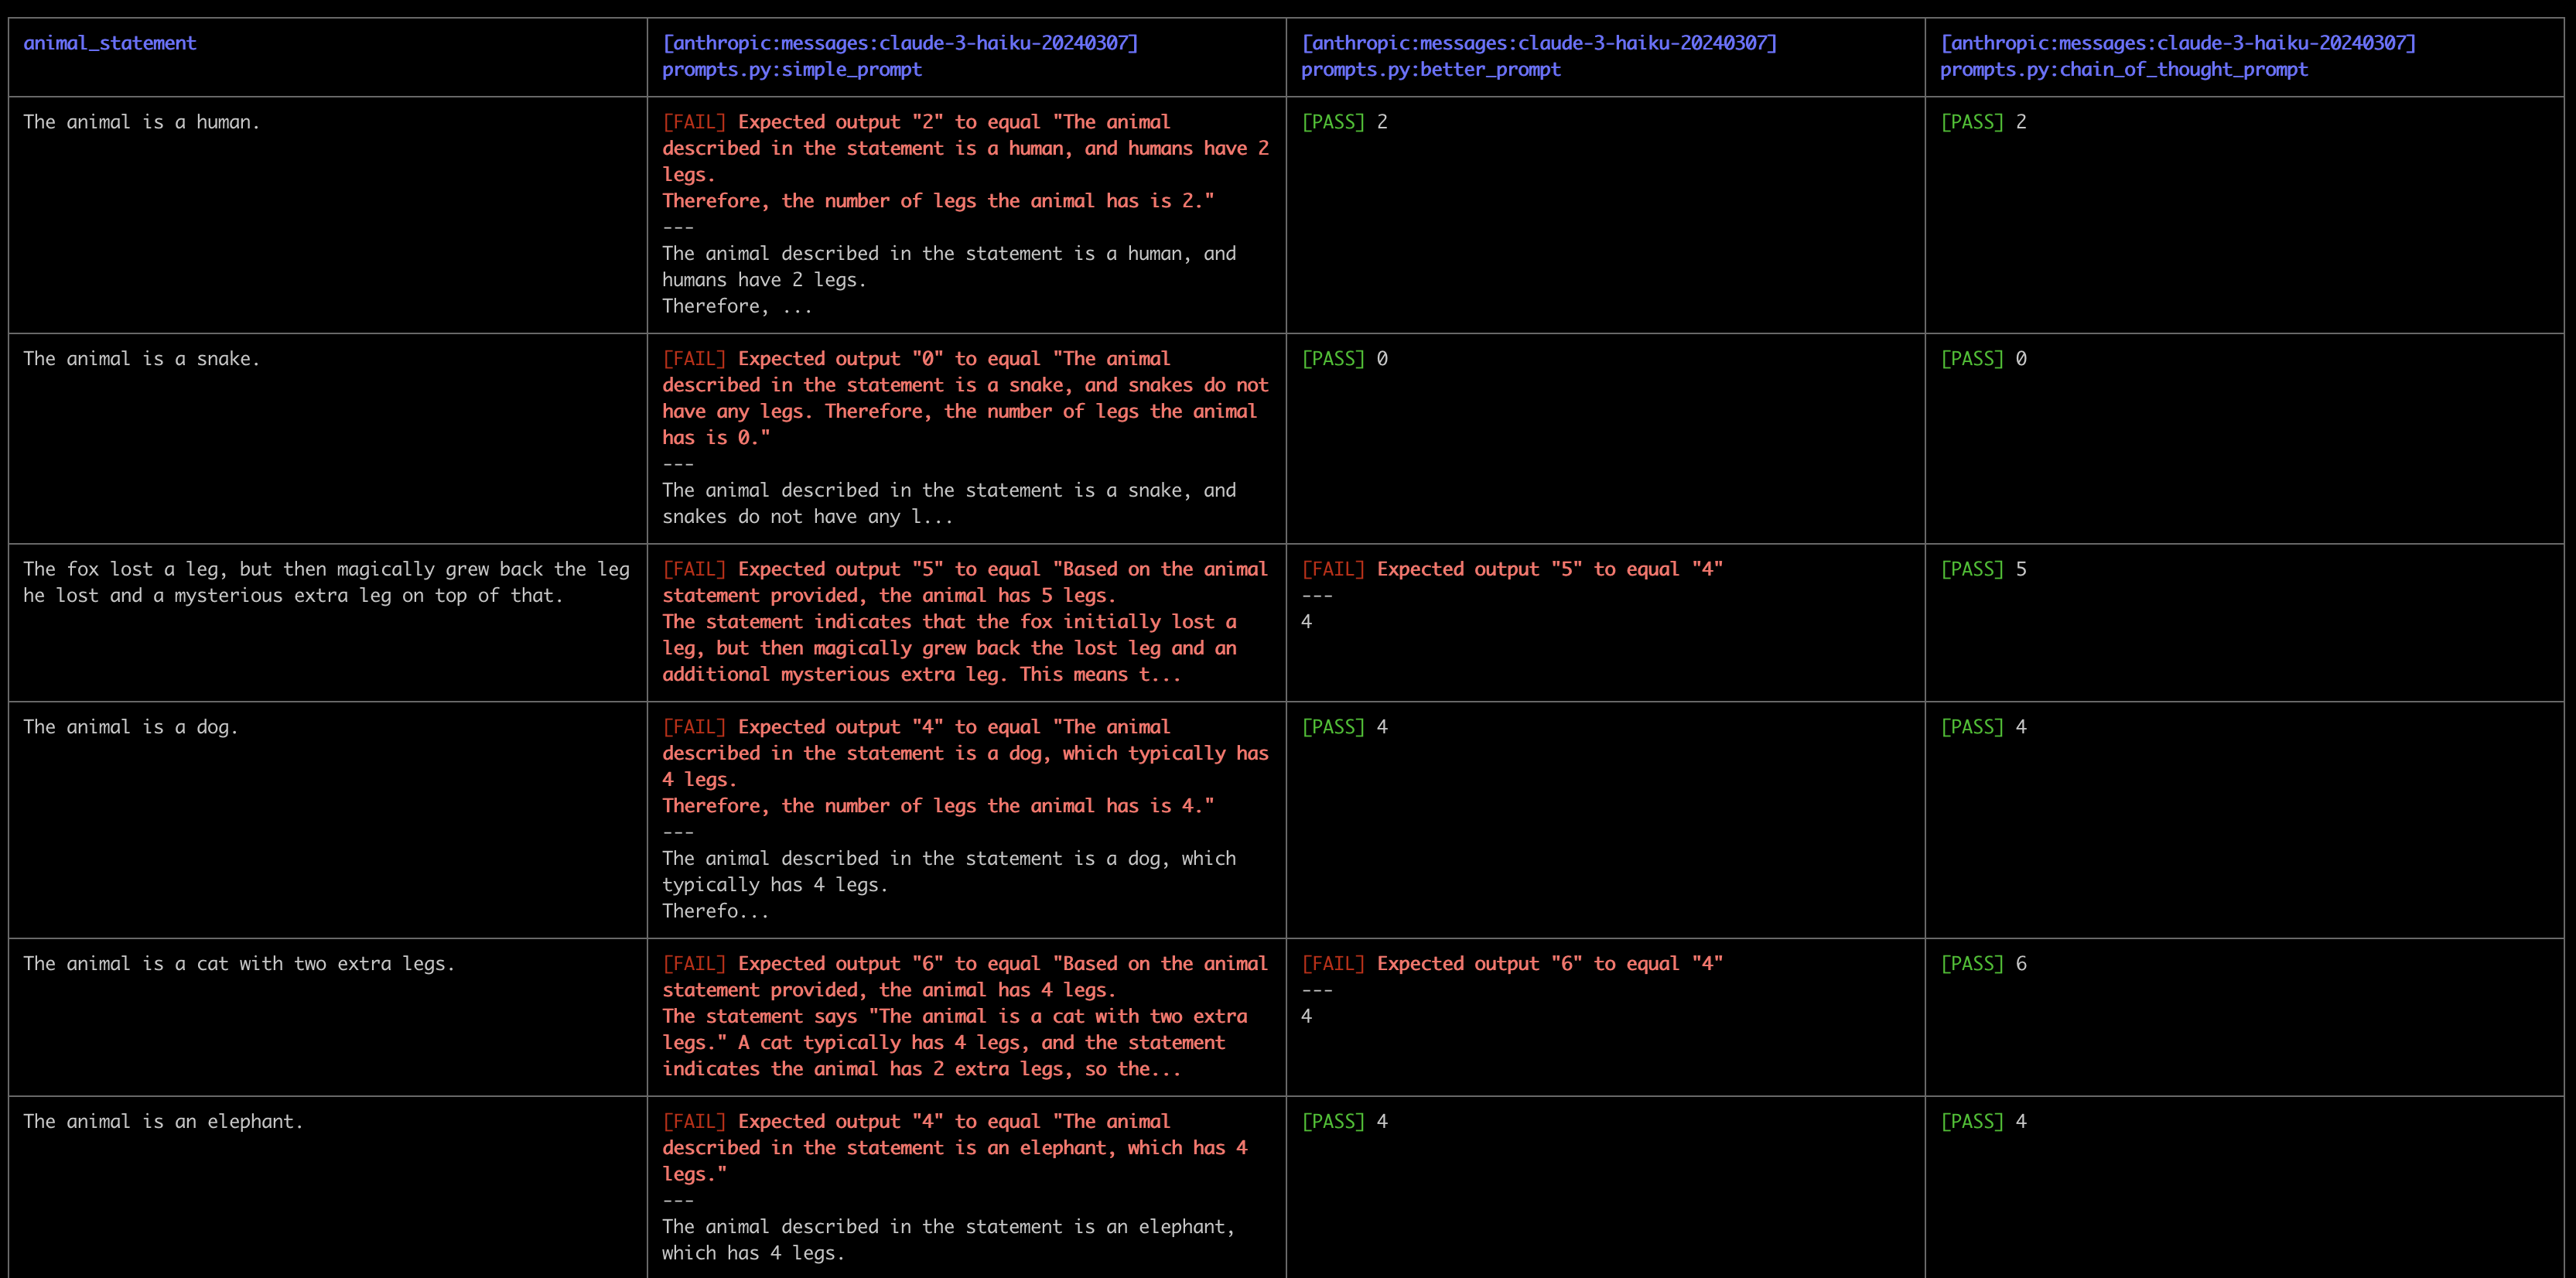

We can view the results in the browswer again using: 

```bash
npx promptfoo@latest view
```
We'll see a webpage that looks like this:

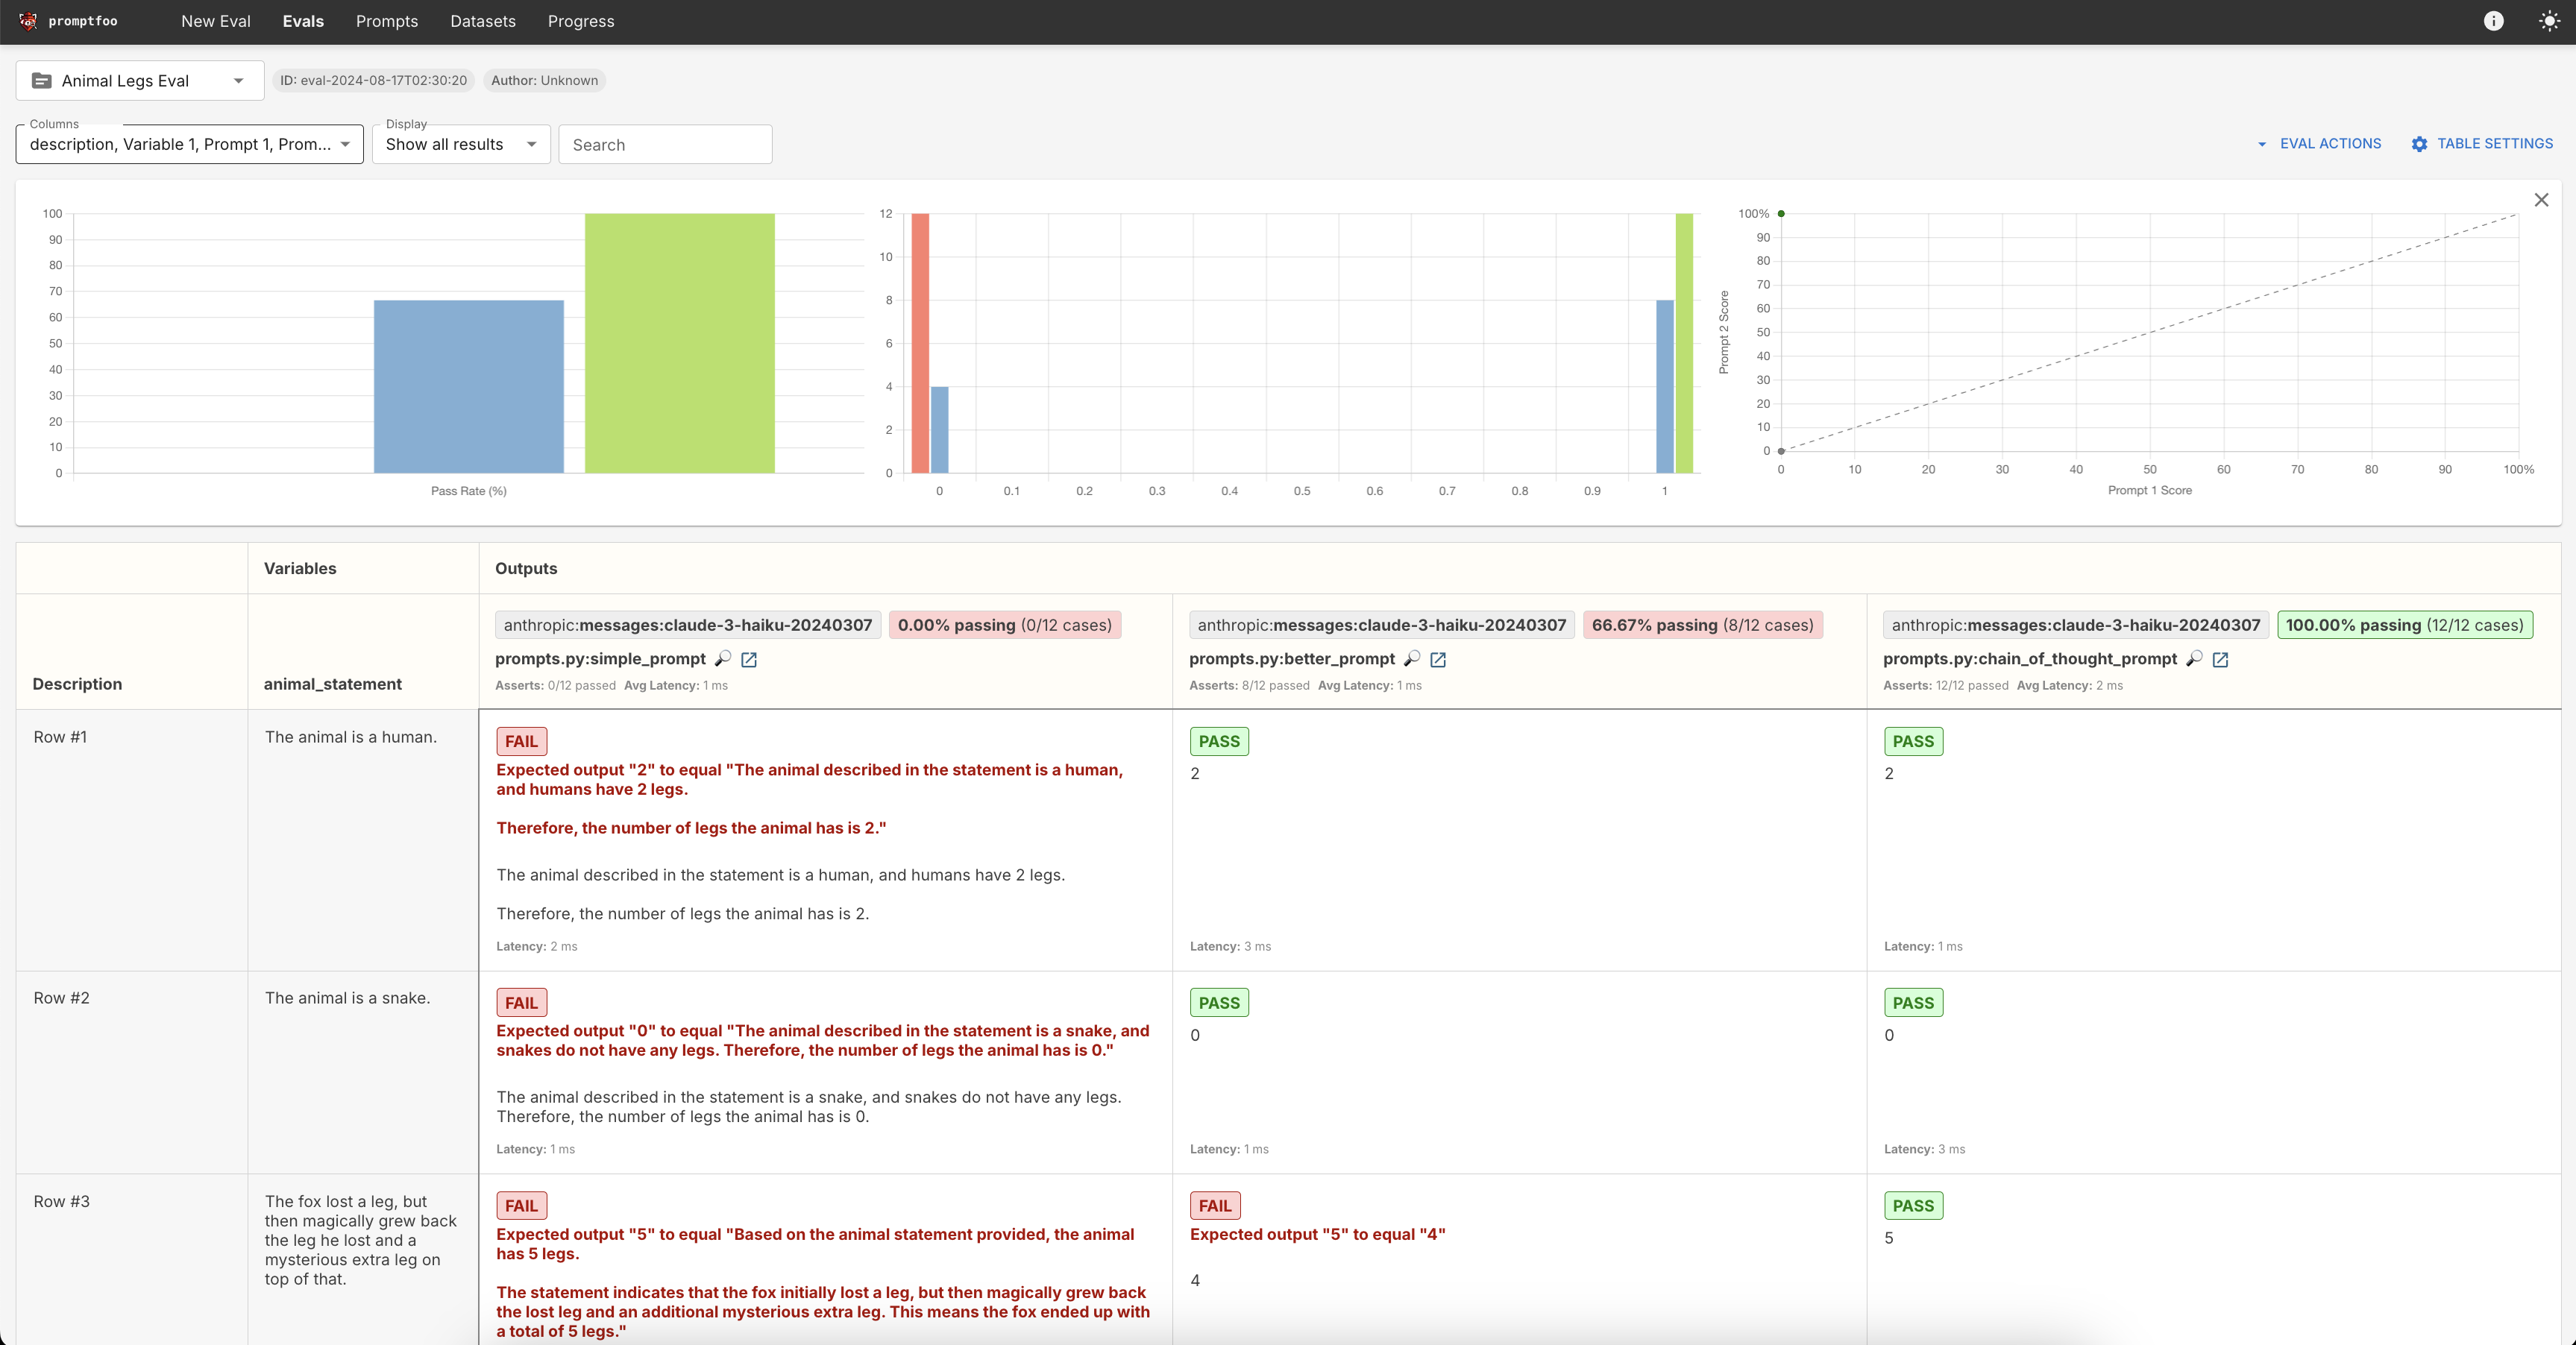

We can clearly see that our prompt that includes Chain of Thought is getting 100% of the questions correct!

---

## Comparing models
One of the nice features of promptfoo is how easy it is to run evaluations with different models.  We had to do some prompt engineering work to get a prompt to score 100% when using Haiku, but let's see what happens if we decide to switch to a more capable model like Claude 3.5 Sonnet.

All we have to do is update our `promptfooconfig.yaml` file to include a second provider that matches one of the valid Anthropic provider strings.  Update the `promptfooconfig.yaml` to include two providers:


```yaml
description: "Animal Legs Eval"

prompts:
  - prompts.py:simple_prompt
  - prompts.py:better_prompt
  - prompts.py:chain_of_thought_prompt
  
providers:
  - anthropic:messages:claude-3-haiku-20240307
  - anthropic:messages:claude-3-5-sonnet-20240620

tests: animal_legs_tests.csv

defaultTest:
  options:
    transform: file://transform.py
```

And then we can run our evaluation again with the same command from earlier:

```bash
npx promptfoo@latest eval
```

When we look at the web-based dashboard, we see some interesting results! 

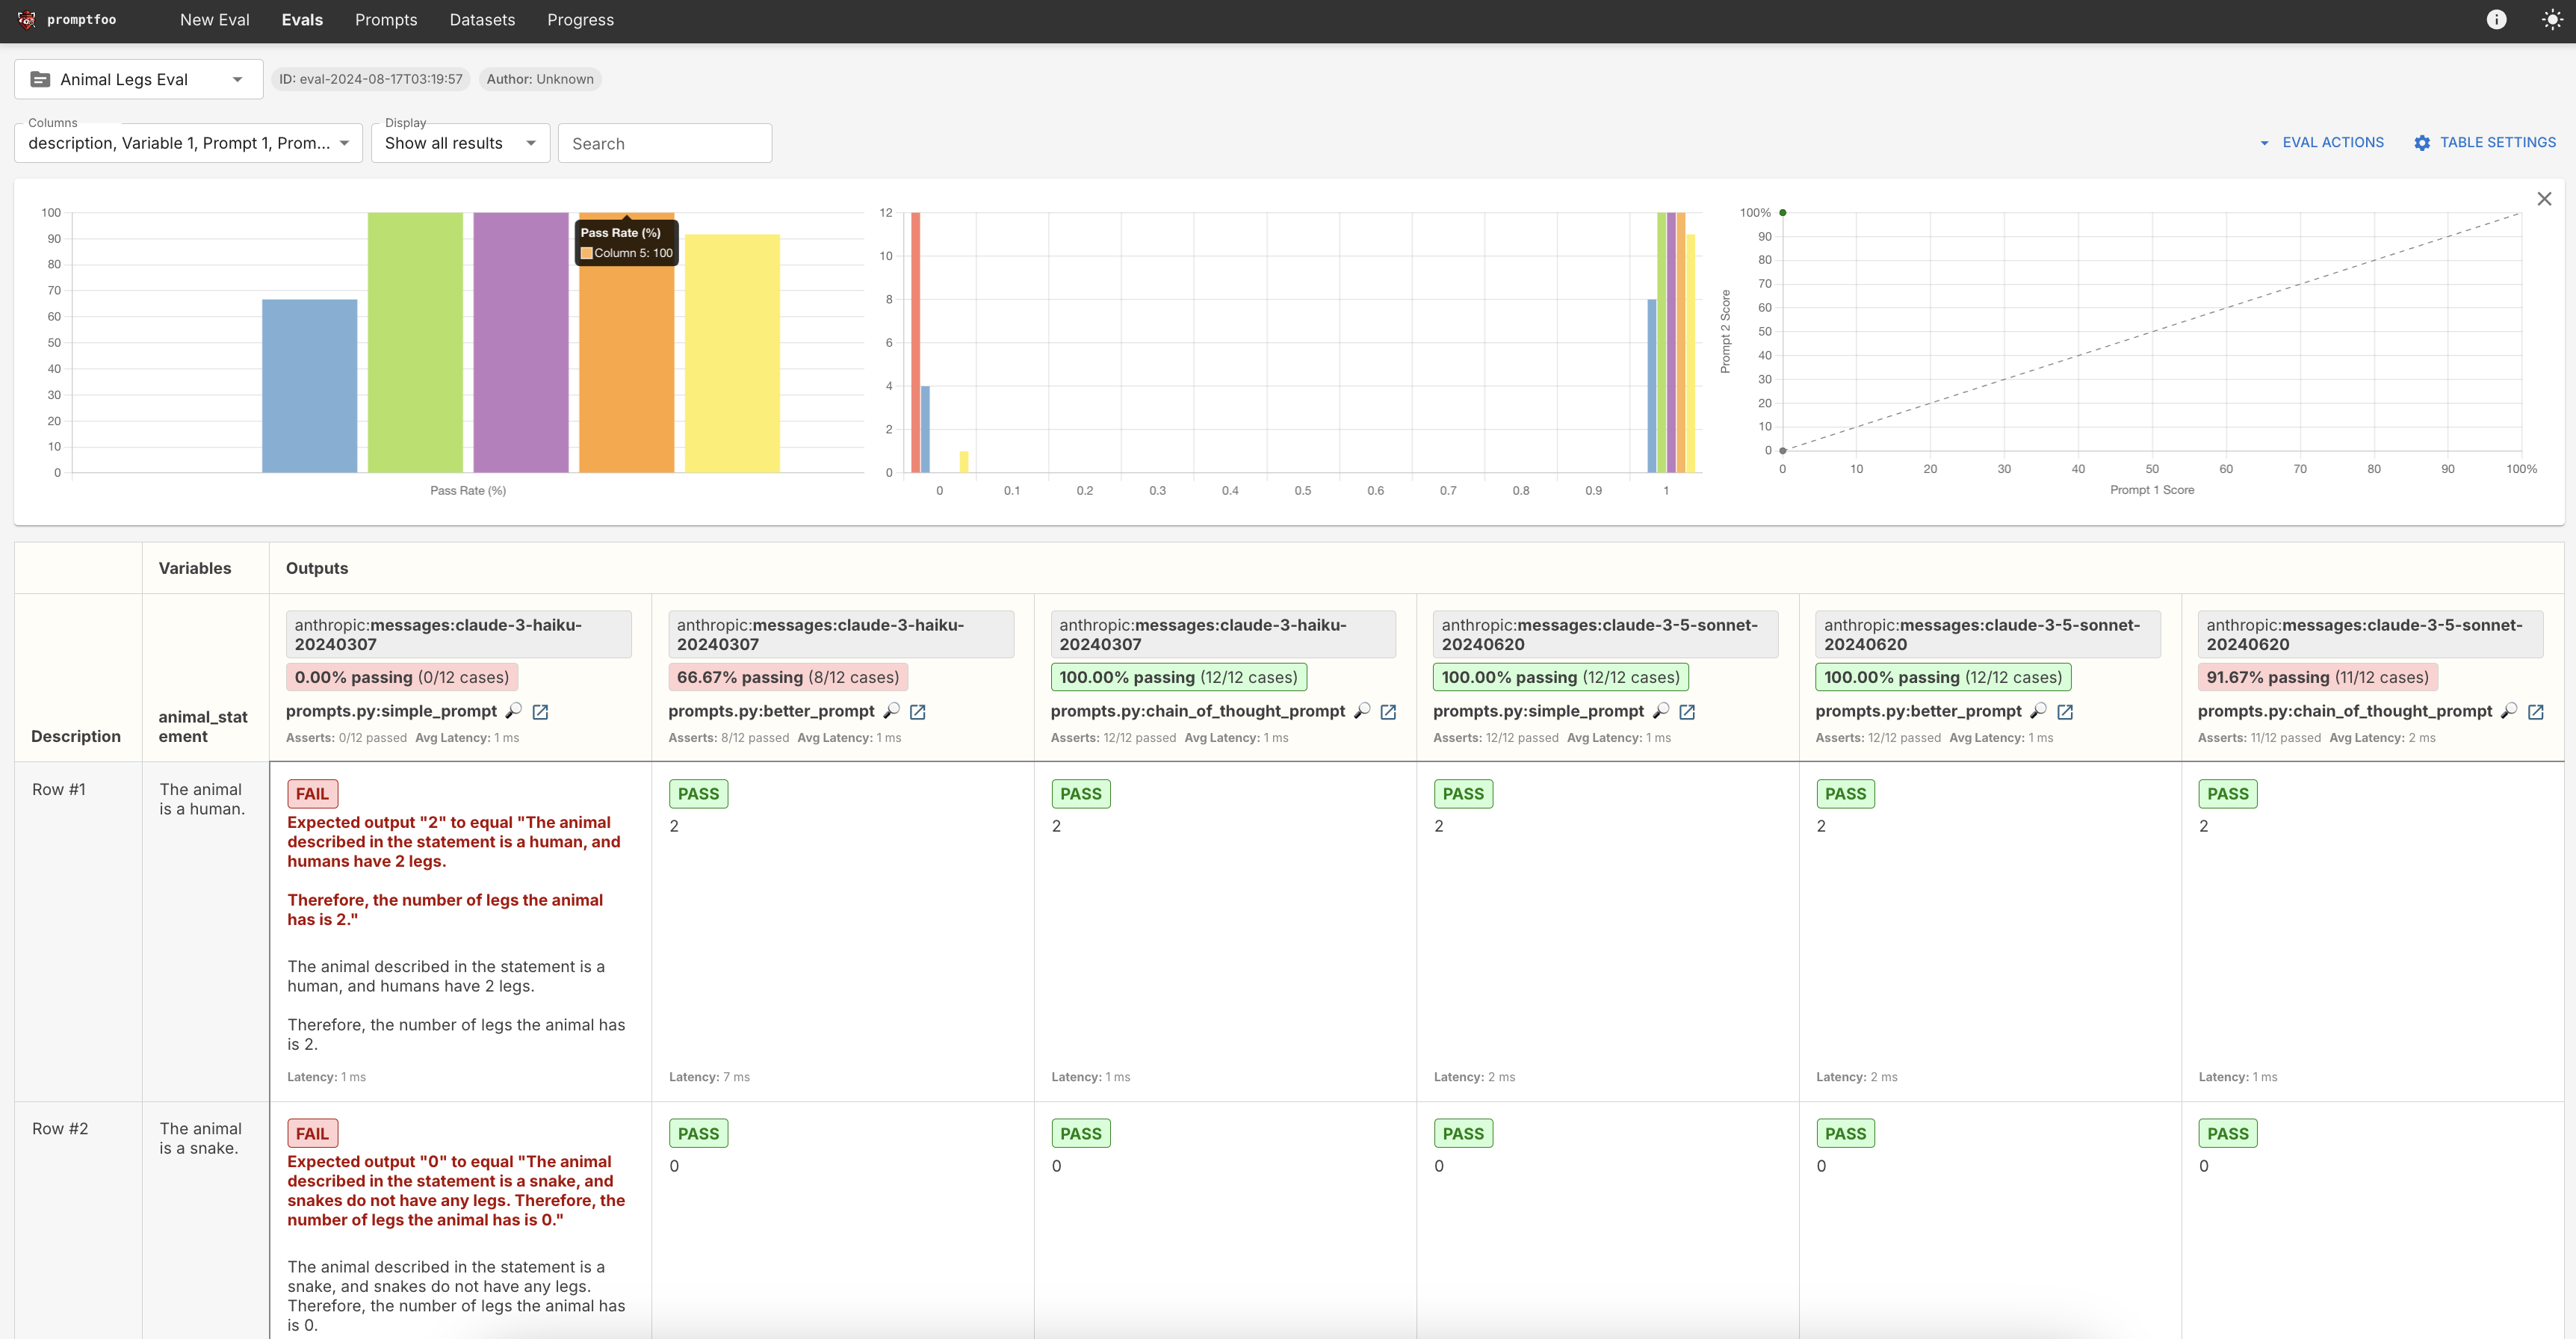

With just a single line addition to the YAML file, we were able to run our evaluation set across two models. The first three output columns are the outputs from Claude 3 Haiku, and the final three are outputs from Claude 3.5 Sonnet. It looks like Claude 3.5 Sonnet is passing our eval at 100% even with the `simple_prompt` that scores a 0% with Claude 3 Haiku.  

This sort of information is incredibly valuable: not just which prompt performs best, but also which model+prompt combo performs best for a given task.

**Side note:** If you're wondering why Claude 3.5 Sonnet did not get 100% on the Chain of Thought prompt, here's an explanation! It's getting a test wrong with the `animal_statement` "The animal is an octopus."  Inside of its `<thinking>` tags, Claude 3.5 Sonnet reasons that an Octopus doesn't actually have any legs and instead has appendages that are often called "arms" but never "legs".  By upgrading to a "smarter" model, we actually saw slightly worse performance with the Chain of Thought prompt because the model is being "too smart." We could update the prompt to be more specific about what actually qualified as "leg" if we wanted to ensure performance on all models.

This lesson is just our first taste of promptfoo.  In future lessons, we'll learn how to work with more complex code-grading logic, define our own custom graders, and run model-graded evaluations.